In [9]:
#from plottable import Table
import pandas as pd
import matplotlib.pyplot as plt
from help_functions import collect_config_to_df, plot_common, plot_comparing_models, get_same_diff_df, show_plots, vizulaize_chunked, create_movie, plot_veff, plot_chunked_veff
import numpy as np
from scipy.stats import chi2_contingency, norm
from scipy.optimize import curve_fit



In [8]:
def gaussian(x, mean, amplitude, standard_deviation):
    return amplitude * np.exp( - (x - mean)**2 / (2*standard_deviation ** 2))


In [4]:
def chi_square_tests(df, target):
    for column in df.columns:
        if column != target:
            contingency_table = pd.crosstab(df[column], df[target])
            chi2, p, dof, expected = chi2_contingency(contingency_table)
            print(f"Chi-square test for {column} and {target}:")
            print(f"Chi-square statistic = {chi2}")
            print(f"p-value = {p}\n")

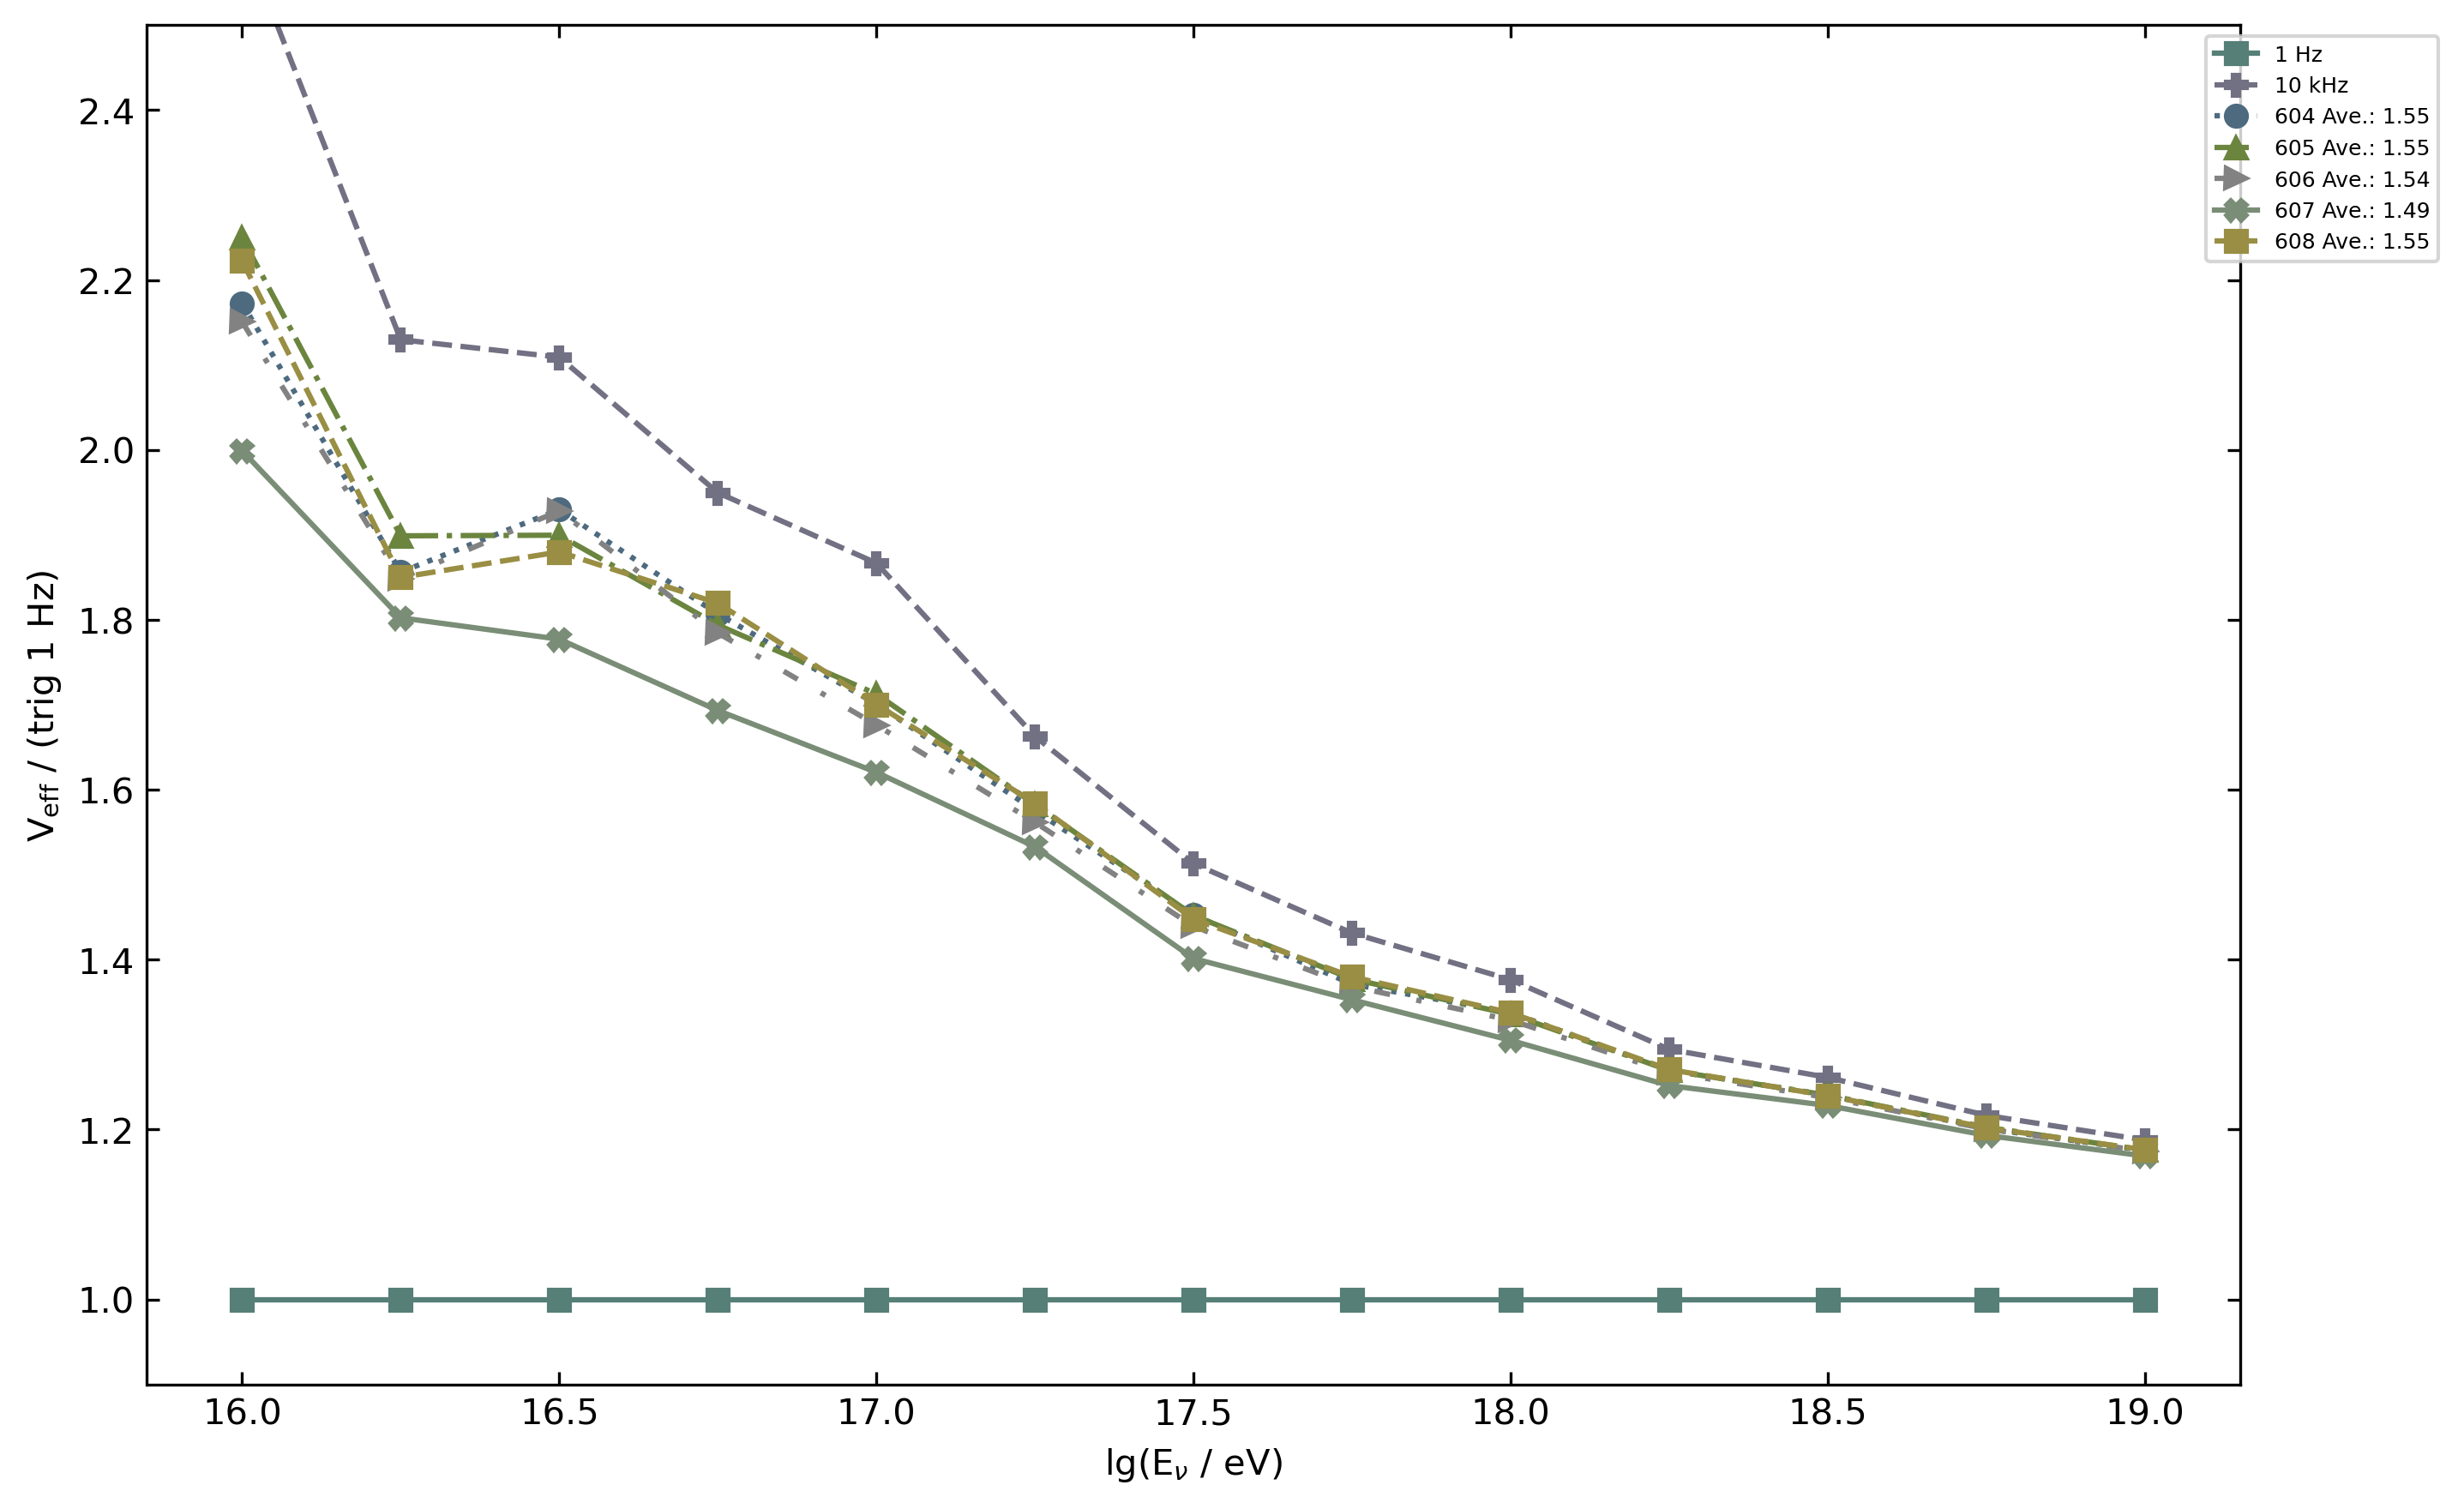

{'604': 1.5453871456441892, '605': 1.5531646509771895, '606': 1.5358854292346407, '607': 1.4866588423708, '608': 1.5469347083055536}
[605 608 604 606 607]
[1.55316465 1.54693471 1.54538715 1.53588543 1.48665884]


In [5]:
models = list(range(604,609))
#models = [256,296,297,298,299]
veff_files = []
for model in models:
    veff_files.append(f'/mnt/md0/halin/Models/model_{model}/plot/QuickVeffRatio_{model}_best.npz')

results = plot_veff(veff_files, plot_path='', y_max=2.5)
models = [int(key) for key in results.keys()]
values = list(results.values())
indices = np.argsort(-np.array(values))

# Use these indices to sort the models and values
models_sorted = np.array(models)[indices]
values_sorted = np.array(values)[indices]
print(models_sorted)
print(values_sorted)

In [12]:
mean = np.mean(values)
std = np.std(values)
print(f"Mean: {mean}")
print(f"Std: {std}")
min_value = np.min(values)
max_value = np.max(values)
cdf_value = norm.cdf(min_value, loc=mean, scale=std)
print(f"Min: {min_value}")
print(f"Max: {max_value}")
print(f"PDF value: {cdf_value}")


Mean: 1.5336061553064746
Std: 0.024117305375218553
Min: 1.4866588423708
Max: 1.5531646509771895
PDF value: 0.025789945712704362


Plot collections of noise reduction factors or roc curve

/software/anaconda3/lib/python3.8/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


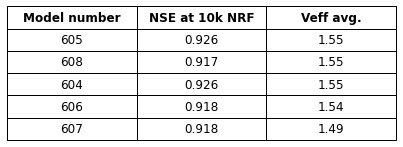

Chi-square test for model_num and Veff avg.:
Chi-square statistic = 20.000000000000004
p-value = 0.22022064660169877

Chi-square test for NSE_AT_10KNRF and Veff avg.:
Chi-square statistic = 20.000000000000004
p-value = 0.22022064660169877

model_num       -0.371834
NSE_AT_10KNRF    0.476758
Veff avg.        1.000000
Name: Veff avg., dtype: float64


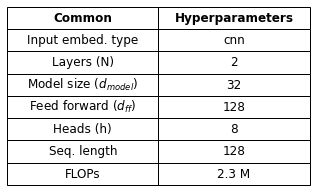

In [6]:
# model_path = '/home/hansalin/dl1/nuradio-analysis/configs/chunked/'
# models = [310,311,312,313,314,315]
model_path = '/mnt/md0/halin/Models/'
#models = list(range(250,300))
evaluate = True
#models = [250,251]

df = collect_config_to_df(models, model_path=model_path, type_of_file='yaml')
if evaluate:
    df['Veff avg.'] = values

sort = True
col_width = 3.0
save = False
prefix = ''
# compare_keys = ['model_num', 'N', 'num_param', 'NSE_AT_10KNRF','MACs']
# compare_df = df[compare_keys]
df_same, df_diff = get_same_diff_df(df)

exclude_columns = [
    # 'activation',
    #'batch_size',
    # 'decreas_factor',
    # 'dropout',
    # #'embed_type',
    #'NSE_AT_10KNRF',
    'encoder_param',
    'num_param',
    # 'encoder_type',
    'final_param',
    # #'final_type',
    'input_param',
    # 'learning_rate',
    # 'location',
    # 'loss_function',
    'max_relative_position',
    # 'n_ant',
    # 'normalization',
    # #'pos_enc_type',
    'pos_param',
    # 'residual_type',
    # 'seq_len',
    # 'step_size',
    # 'encode_type',
    'training_time',
    'MACs'

]
if df_diff.empty:
    print('No common values')
    plot_comparing_models(df_same.iloc[[0]], 
                          row_height=0.35, 
                          col_width=col_width, 
                          sort=sort, 
                          exclude_columns=exclude_columns, 
                          save=save,
                          prefix=prefix
                          )
    exclude_columns = [
        'N',
        'MACs',
        'NSE_AT_10KNRF',
        'activation',
        'd_ff',
        'd_model',
        'embed_type',
        'encoder_param',
        'encoder_type',
        'final_param',
        'final_type',
        'h',
        'input_param',
        'location',
        
        'max_relative_position',
        'model_num',
        'n_ant',
        'normalization',
        'num_param',
        #'pos_enc_type',
        'pos_param',
        'residual_type',
        'encode_type',
        'training_time',
    ]
    plot_common(df_same.iloc[[0]] , 
                row_height=0.4, 
                col_width=col_width+0.5, 
                exclude_columns=exclude_columns, 
                save=save,
                prefix=prefix,
                )
else:
    df = plot_comparing_models(df_diff, 
                          row_height=0.35, 
                          col_width=col_width, 
                          sort=sort, 
                          exclude_columns=exclude_columns, 
                          save=save,
                          prefix=prefix,
                          )
    categorical_values = ['Pos. enc. type', 'Act. function', 'Input embed. type', 'Loss function', 'Projection type']
    if evaluate:
        chi_square_tests(df, 'Veff avg.')
        correlation = df.corr()['Veff avg.']
        print(correlation)  
    exclude_columns = [
    'activation',
    'batch_size',
    'decreas_factor',
    'dropout',
    #'embed_type',
    'encoder_param',
    'encoder_type',
    'final_param',
    'final_type',
    'input_param',
    'num_param',
    'learning_rate',
    'location',
    'loss_function',
    'max_relative_position',
    'n_ant',
    'normalization',
    'pos_enc_type',
    'pos_param',
    'residual_type',
    # 'seq_len',
    'step_size',
    'encode_type',
    'training_time',
    'MACs',
    'NSE_AT_10KNRF',
    'max_pool',
    'FLOP',
    'step_size',
    'learning_rate',
    'projection_type',

]
    plot_common(df_same.iloc[[0]] , 
                row_height=0.4, 
                col_width=col_width + 0.5, 
                exclude_columns=exclude_columns, 
                save=save,
                prefix=prefix,
                )
# show_plots(model_num=200, search_string='roc')   